In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Tutorial link: https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [3]:
dataframe = pd.read_csv("final.csv")

In [4]:
dataframe.dropna(inplace=True)

In [5]:
dataframe['target'] = dataframe['MB']

In [6]:
dataframe = dataframe.drop(['MB'], axis=1)

In [7]:
X = dataframe.drop(['target'], axis=1)
y = dataframe['target']

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
feature_columns = []

for header in ["q8", "q9", "q10", "q11", "q12", "q17",	"q19", "q26", "q27", "q28",	"q29", "q30", "q31", "q35", "q38", "q39", "q46", "q49", "q50", "q51", "q52", "q53", "q54", "q55",	"q58", "q59", "q60", "q61",	"q74", "q75", "q79", "q80", "q81", "q82", "q84", "q85", "q87", "q92"]:
    feature_columns.append(feature_column.numeric_column(header))


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [10]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer = tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],))  # This is for numeric inputs


In [14]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [16]:
model = tf.keras.Sequential([
    input_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [18]:
def specificity(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), 'float'))
    false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), 'float'))
    
    specificity = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity

In [20]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  specificity,
                  tf.keras.metrics.Recall(name='sensitivity'),
                  f1_score
                      ]
             )

In [24]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

Epoch 1/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1470 - accuracy: 0.9395 - auc: 0.8842 - specificity: 0.9751 - sensitivity: 0.7190 - f1_score: 0.7742 - val_loss: 0.0879 - val_accuracy: 0.9613 - val_auc: 0.9371 - val_specificity: 0.9758 - val_sensitivity: 0.8412 - val_f1_score: 0.8782
Epoch 2/10
368/368 [==============================] - 0s 851us/step - loss: 0.0713 - accuracy: 0.9693 - auc: 0.9524 - specificity: 0.9831 - sensitivity: 0.8776 - f1_score: 0.9020 - val_loss: 0.0697 - val_accuracy: 0.9715 - val_auc: 0.9746 - val_specificity: 0.9699 - val_sensitivity: 0.9338 - val_f1_score: 0.9082
Epoch 3/10
368/368 [==============================] - 0s 855us/step - loss: 0.0516 - accuracy: 0.9785 - auc: 0.9620 - specificity: 0.9872 - sensitivity: 0.9054 - f1_score: 0.9204 - val_loss: 0.0509 - val_accuracy: 0.9727 - val_auc: 0.9476 - val_specificity: 0.9951 - val_sensitivity: 0.8515 - val_f1_score: 0.9358
Epoch 4/10
368/368 [==============================] - 0s 1ms

In [26]:
model.evaluate(
    test_ds,
)

123/123 [==============================] - 0s 604us/step - loss: 0.0359 - accuracy: 0.9860 - auc: 0.9878 - specificity: 0.9849 - sensitivity: 0.9762 - f1_score: 0.9522


[0.03591902181506157,
 0.9859872460365295,
 0.9877795577049255,
 0.9849080443382263,
 0.9762219190597534,
 0.9521682858467102]

In [28]:
import shap


In [30]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 73ms/step


  0%|          | 0/3925 [00:00<?, ?it/s]

664/664 [==============================] - 0s 539us/step


In [35]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(3925, 38)


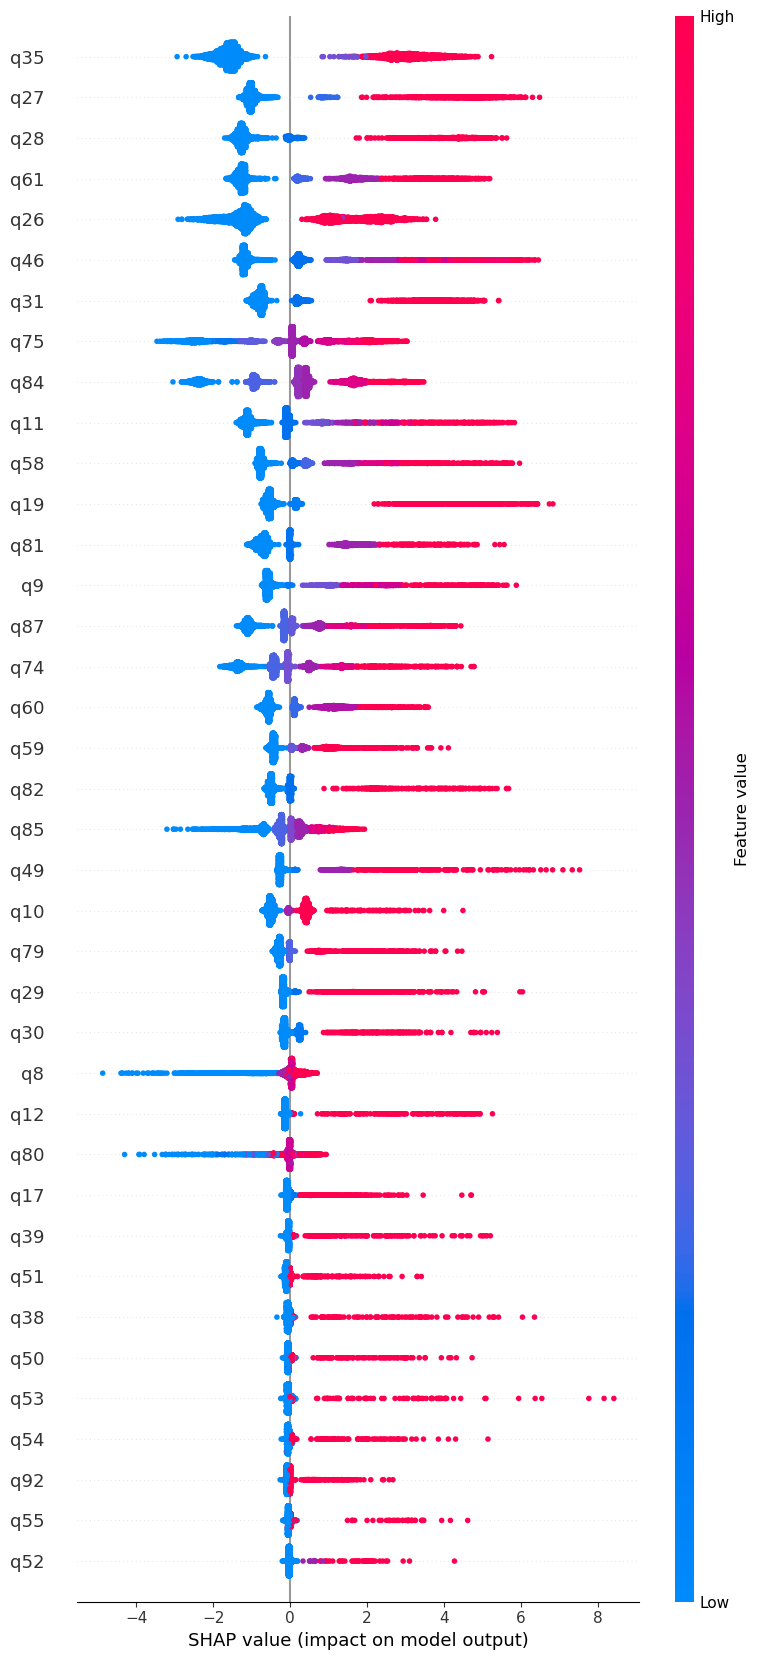

In [37]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])